<a name="lib"></a>

# Import libraries and packages

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
maindf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UL (1).csv')
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
maindf

,date,open,high,low,close,adj_close,volume
0,2019-06-04,61.389999,61.450001,60.959999,61.380001,51.540009,656800
1,2019-06-05,61.669998,61.950001,61.540001,61.700001,51.808697,629600
2,2019-06-06,61.860001,62.209999,61.770000,62.080002,52.127773,640300
3,2019-06-07,62.330002,62.730000,62.320000,62.529999,52.505650,621700
4,2019-06-10,62.090000,62.290001,61.930000,62.270000,52.287323,619700
...,...,...,...,...,...,...,...
1254,2024-05-28,54.419998,54.419998,54.029999,54.130001,54.130001,2190000
1255,2024-05-29,53.820000,53.880001,53.500000,53.529999,53.529999,2422300
1256,2024-05-30,54.080002,54.279999,54.020000,54.049999,54.049999,3210400
1257,2024-05-31,54.209999,54.779999,54.150002,54.750000,54.750000,2394200


In [ ]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  1259
Total number of fields:  7


<a name="na"></a>

# Memeriksa nilai Null dan NA / Checking Null and NA value

In [ ]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


<a name="predate"></a>

# Ubah kolom Tanggal ke format datetime / Convert Date field into datetime format

In [ ]:
# convert date field from string to Date format
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2019-06-04,61.389999,61.450001,60.959999,61.380001,51.540009,656800
1,2019-06-05,61.669998,61.950001,61.540001,61.700001,51.808697,629600
2,2019-06-06,61.860001,62.209999,61.770000,62.080002,52.127773,640300
3,2019-06-07,62.330002,62.730000,62.320000,62.529999,52.505650,621700
4,2019-06-10,62.090000,62.290001,61.930000,62.270000,52.287323,619700


<a name="eda"></a>

# EDA - Exploratory Data Analysis

<a name="dur"></a>

### Temukan durasi dataset / Find the duration of dataset

In [ ]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2019-06-04 00:00:00
Ending date:  2024-06-03 00:00:00
Duration:  1826 days 00:00:00


<a name="oc"></a>

### Perbandingan Harga Saham Buka dan Tutup per Bulan / Monthwise comparision between Stock open and close price

In [ ]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,53.547822,53.624060
February,53.273646,53.298021
March,50.193063,50.273063
April,51.352524,51.349320
May,52.699143,52.706952
June,54.851038,54.835000
July,55.589714,55.587905
August,55.174775,55.147027
September,54.585825,54.504272


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

<a name="hl"></a>

### Harga saham tertinggi dan terendah per bulan / Monthwise High and Low stock price

In [ ]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

<a name="trend"></a>

### Perbandingan tren antara harga pembukaan saham, harga penutupan, harga tertinggi, harga terendah / Trend comparision between stock open price, close price, high price, low price

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'],
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<a name="sc"></a>

**Di sini, Kami akan memprediksi harga penutupan untuk 30 hari ke depan / Here, We are going to predict close price for next 30 days**

# Siapkan Harga Penutupan Saham / Prepare Stock Close price

<a name="df"></a>

### Buat kerangka data terpisah dari harga penutupan / Make separate dataframe of close price

In [ ]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1259, 2)


<a name="pclose"></a>

### Membuat grafik harga penutupan saham

In [ ]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="year"></a>

# Pertimbangkan hanya data 3 tahun terakhir untuk prediksi / Consider only last 3 year data for prediction

In [ ]:
closedf = closedf[closedf['date'] > '2021-06-03']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  754


In [ ]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="norm"></a>

### Menormalkan harga penutupan / Normalizing close price

In [ ]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(754, 1)


<a name="split"></a>

### Siapkan Data untuk pelatihan dan pengujian / Prepare Data for train and test

In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (452, 1)
test_data:  (302, 1)


<a name="trans"></a>

### Transformasi Tutup harga berdasarkan kebutuhan peramalan analisis deret waktu / Transform Close price base on Time-series-analysis forecasting requirement

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (436, 15)
y_train:  (436,)
X_test:  (286, 15)
y_test (286,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (436, 15, 1)
X_test:  (286, 15, 1)


<a name="gru"></a>

# Pembangungan Model / Model Building (GRU)

**GRUs (Gated Recurrent Units) are very similar to Long Short Term Memory(LSTM). Just like LSTM, GRU uses gates to control the flow of information. They are relatively new as compared to LSTM. This is the reason they offer some improvement over LSTM and have simpler architecture.**

\

GRUs (Gated Recurrent Units) sangat mirip dengan Long Short Term Memory (LSTM). Sama seperti LSTM, GRU menggunakan gerbang untuk mengendalikan aliran informasi. GRU tergolong baru dibandingkan dengan LSTM. Inilah alasannya mengapa GRU menawarkan beberapa peningkatan dibandingkan LSTM dan memiliki arsitektur yang lebih sederhana..

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
14/14 [==============================] - 9s 114ms/step - loss: 0.0661 - val_loss: 0.0191
Epoch 2/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0171 - val_loss: 0.0074
Epoch 3/200
14/14 [==============================] - 0s 28ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 4/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 5/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 6/200
14/14 [==============================] - 0s 28ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 7/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 8/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 9/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 10/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0048 - val_loss: 0.002

<a name="loss"></a>

### Merencanakan grafik kerugian / Plotting loss chart

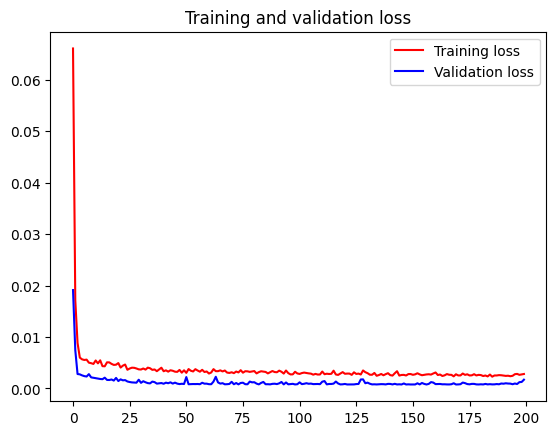

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

9/9 [==============================] - 0s 7ms/step


((436, 1), (286, 1))

<a name="eval"></a>

# Evaluasi Model / Model Evaluation

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

<a name="mse"></a>

### Metrik Evaluasi / Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.9043230060188865
Train data MSE:  0.8178000992150349
Train data MAE:  0.6763836101964551
-------------------------------------------------------------------------------------
Test data RMSE:  0.7351104025729674
Test data MSE:  0.5403873039709902
Test data MAE:  0.5940930445018846


<a name="var"></a>

### Penjelasan skor regresi varians / Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors. \
\
Skor varians yang dijelaskan menjelaskan penyebaran kesalahan dari kumpulan data tertentu, dan rumusnya ditulis sebagai berikut: Di sini, dan Var(y) adalah varians kesalahan prediksi dan nilai aktual. Skor yang mendekati 1,0 sangat diinginkan, yang menunjukkan kuadrat deviasi standar kesalahan yang lebih baik.

In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9662111300286301
Test data explained variance regression score: 0.9521570303512394


<a name="r2"></a>

### R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

\
R-kuadrat (R2) adalah ukuran statistik yang menunjukkan proporsi varians untuk variabel dependen yang dijelaskan oleh variabel independen atau variabel-variabel dalam model regresi.

1 = Terbaik <br>
0 atau < 0 = lebih buruk

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9553612339495242
Test data R2 score: 0.9007663402203842


<a name="mpd"></a>

### Kerugian Regresi Kerugian regresi deviasi Gamma rata-rata (MGD) dan kerugian regresi deviasi Poisson rata-rata (MPD) / Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0003236514605665174
Test data MGD:  0.0002103426425942852
----------------------------------------------------------------------
Train data MPD:  0.016216633166329975
Test data MPD:  0.010650900333570891


<a name="cp"></a>

# Perbandingan harga penutupan saham asli dan harga penutupan prediksi / Comparison of original stock close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (754, 1)
Test predicted data:  (754, 1)


<a name="days"></a>

# Memprediksi 30 hari ke depan / Predict next 30 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


<a name="pdays"></a>

### Memplot 15 hari terakhir dari dataset dan prediksi 30 hari ke depan / Plotting the last 15 days of the dataset and predicting the next 30 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="pwhole"></a>

### Memplot seluruh Harga Saham Penutupan dengan periode prediksi 30 hari ke depan / Plotting whole stock price with prediction

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()